In [1]:
import os
import sys
import time
import math
import random
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from loader.load_uavid import uavidloader
from network.net import deeplab_resnet
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def get_Hrrs_label():
    return np.asarray(
                      [
              [  0,   0,   0],  # background clutter
              [128,   0,   0],  # building
		      [128,  64, 128],  # road
		      [  0, 128,   0],  # tree
		      [128, 128,   0],  # low vegetation
		      [ 64,   0, 128],  # moving car
		      [192,   0, 192],  # static car
		      [ 64,  64,   0]   # human
                    ])

def decode_segmap(label_mask, n_classes = 8):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
        the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
        in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """
    label_colours = get_Hrrs_label()

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype=np.uint8)
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b
    return rgb

def tta_inference(inp, model, num_classes=8, scales=[1.0], flip=True):
    b, _, h, w = inp.size()
    preds = inp.new().resize_(b, num_classes, h, w).zero_().to(inp.device)
    for scale in scales:
        size = (int(scale*h), int(scale*w))
        resized_img = F.interpolate(inp, size=size, mode='bilinear', align_corners=True,)
        pred = model_inference(model, resized_img.to(inp.device), flip)
        pred = F.interpolate(pred, size=(h, w), mode='bilinear', align_corners=True,)
        preds += pred

    return preds/(len(scales))

def model_inference(model, image, flip=True):
    output = model(image)
    if flip:
        fimg = image.flip(2)
        output += model(fimg).flip(2)
        fimg = image.flip(3)
        output += model(fimg).flip(3)
        return output/3
    return output

In [3]:
def slide(model, scale_image, num_classes=8, crop_size=512, overlap=1/2, scales=[1.0], flip=True):

    N, C, H_, W_ = scale_image.shape
    
    full_probs = torch.zeros((N, num_classes, H_, W_), device=scale_image.device) #
    count_predictions = torch.zeros((N, num_classes, H_, W_), device=scale_image.device) #

    h_overlap_length = int(overlap*H_)
    w_overlap_length = int(overlap*W_)

    h = 0
    slide_finish = False
    while not slide_finish:

        if h + crop_size <= H_:

            # set row flag
            slide_row = True
            # initial row start
            w = 0
            while slide_row:
                if w + crop_size <= W_:
                    patch_image = scale_image[:, :, h:h+crop_size, w:w+crop_size]
                    #
                    patch_pred_image = tta_inference(patch_image, model, num_classes=num_classes, scales=scales, flip=flip)
                    count_predictions[:,:,h:h+crop_size, w:w+crop_size] += 1
                    full_probs[:,:,h:h+crop_size, w:w+crop_size] += patch_pred_image

                else:
                    patch_image = scale_image[:, :, h:h+crop_size, W_-crop_size:W_]
                    #
                    patch_pred_image = tta_inference(patch_image, model, num_classes=num_classes, scales=scales, flip=flip)
                    count_predictions[:,:,h:h+crop_size, W_-crop_size:W_] += 1
                    full_probs[:,:,h:h+crop_size, W_-crop_size:W_] += patch_pred_image
                    slide_row = False

                w += w_overlap_length

        else:
            # set last row flag
            slide_last_row = True
            # initial row start
            w = 0
            while slide_last_row:
                if w + crop_size <= W_:
                    patch_image = scale_image[:,:,H_-crop_size:H_, w:w+crop_size]
                    #
                    patch_pred_image = tta_inference(patch_image, model, num_classes=num_classes, scales=scales, flip=flip)
                    count_predictions[:,:,H_-crop_size:H_, w:w+crop_size] += 1
                    full_probs[:,:,H_-crop_size:H_, w:w+crop_size] += patch_pred_image

                else:
                    patch_image = scale_image[:,:,H_-crop_size:H_, W_-crop_size:W_]
                    #
                    patch_pred_image = tta_inference(patch_image, model, num_classes=num_classes, scales=scales, flip=flip)
                    count_predictions[:,:,H_-crop_size:H_, W_-crop_size:W_] += 1
                    full_probs[:,:,H_-crop_size:H_, W_-crop_size:W_] += patch_pred_image

                    slide_last_row = False
                    slide_finish = True

                w += w_overlap_length

        h += h_overlap_length

    full_probs /= count_predictions

    return full_probs

In [4]:
def predict_sliding(model, image, num_classes=8, crop_size=512, overlap=1/2, scales=[1.0], flip=True):

    N, C, H, W = image.shape
    full_probs = slide(
        model, 
        image, 
        num_classes=num_classes, 
        crop_size=crop_size, 
        overlap=overlap, 
        scales=scales, 
        flip=flip)

    full_probs = F.interpolate(full_probs, size=(H, W), mode='bilinear', align_corners=True)

    return full_probs

In [5]:
def test(testloader, model, savedir, device):
    '''
    args:
        test_loaded for test dataset
        model: model
    return:
        mean,Iou,IoU class
    '''
    if not os.path.exists(savedir):
        os.mkdir(savedir)

    model.eval()
    total_batches = len(testloader)
    with torch.no_grad():
        for idx, batch in enumerate(testloader):
            # load data
            # print(batch)
            image, _,  name = batch
            image = image.to(device)
            N, C, H, W = image.shape

            print(f"H={H} and W={W} using slide.")
            output = predict_sliding(
                model=model,
                image=image,
                num_classes=8,
                crop_size=512,
                overlap=1/3,
                scales=[0.75, 1.0, 1.25],
                flip=True)

            _, output = torch.max(output, 1)

            assert len(output.shape) == 3, f"Wrong shape!"
            # convert torch to array
            output = np.asarray(output.permute(1,2,0).data.cpu().numpy(), dtype=np.uint8)

            # input: [H, W, 3]
            imageout = decode_segmap(output.squeeze())

            # std output
            img_save_name = os.path.basename(name[0])
            img_save_name = os.path.splitext(img_save_name)[0]

            img_save_path = os.path.join(savedir, img_save_name+'_gt.png')
            imageout = Image.fromarray(imageout)
            imageout.save(img_save_path)

In [6]:
input_path_testA = './data/uavid_crop'
output_path_testA = './data/uavid_test/try/'

In [7]:
cudnn.enabled = True     # Enables bencnmark mode in cudnn, to enable the inbuilt
cudnn.benchmark = True   # cudnn auto-tuner to find the best algorithm to use for
                            # our hardware
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(0)

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.3918, 0.4114, 0.3726], [0.1553, 0.1528, 0.1456]),
])

testA_set = uavidloader(root=input_path_testA, split='test')
testA_loader = DataLoader(testA_set, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

model = deeplab_resnet.DeepLabv3_plus(
                    nInputChannels=3,
                    n_classes=8,
                    os=8,
                    pretrained=True
                    ).to(device)

model = torch.nn.DataParallel(model, device_ids=[0])

checkpoint = torch.load('runs_uavid/deeplabv3+_res101_4e-3/deeplanb3+bs4gpu4/model.pth', map_location='cuda:0')
model.load_state_dict(checkpoint)
deeplab = model.to(device)

# start = time.time()
# test(testA_loader, deeplab, output_path_testA, device)
# print(f"testA finish")
# runtime1 = time.time() - start
# print(f"Spend Time: {math.floor(runtime1//3600):2d}h:"
# f"{math.floor(runtime1%3600//60):2d}m:{math.floor(runtime1%60):2d}s")

u dataset have 150 images.
Constructing DeepLabv3+ model...
Number of classes: 8
Output stride: 8
Number of Input Channels: 3


In [8]:
image, _,  name = next(iter(testA_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


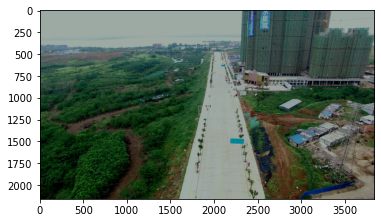

In [10]:
plt.imshow(image.permute(0,2,3,1).squeeze(0).data.cpu().numpy())

In [15]:
deeplab = deeplab.eval()
with torch.no_grad():
    pred = slide(deeplab, image.to(device), num_classes=8, crop_size=512, overlap=1/2, scales=[1.0], flip=True)

In [16]:
pred.shape

torch.Size([1, 8, 2160, 3840])

In [17]:
_, out = torch.max(pred, 1)

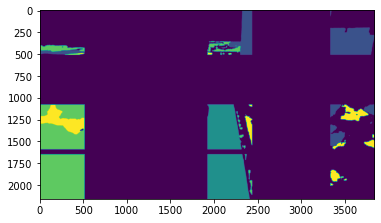

In [19]:
plt.imshow(out.squeeze(0).data.cpu())